#<center> <b>Transfer Learning using Tensorflow</b>

##Explanation:
In this notebook, I will explore the transfer learning approach in the deep learning methodology. The transfer learning approach is a technique where the weight of an already trained model can be loaded and used later. For this I will use ResNet50. The ResNet50 is a 50 deep layer Convolutional Neural Network (CNN) and the network is trained on more than million images from the ImageNet database. In the following, the top layer is not used and two additional layers are added. And the model is trained to figure out the weight for added layers. For more detailed information on the ResNet, see https://iq.opengenus.org/resnet50-architecture/ 

For information on using ResNet50 with Tensorflow, see
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50

<center><b><font size='5'>Import Modules:</b>

In [ ]:
#Import necessary libraries for the neural network
import tensorflow as tf
from tensorflow.keras.layers import  Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

#Library or module for data manipulation
import numpy as np

#Library for visulization purpose
import matplotlib.pyplot as plt
import PIL

#To import data via url
import pathlib

#To read the picture, this model also has many great features
#Which is not explore here
import cv2

<center><b><font size='5'>Load data:</font></b>

After the necessary modules have been imported, data is loaded in the next step. The data file is stored in /root/.keras (in google colab). 

In [ ]:
#location of data in the server
path_to_data = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
dir_to_data  = tf.keras.utils.get_file('flower_photos',origin=path_to_data,untar=True)
dir_to_data  = pathlib.Path(dir_to_data)

In the following code cell data is read from directory. 

* The first argument dir_to_data is the path where the data is located.

* Labels for images are automatically derived from the name of the subdirectory. The label_model is integer by default, but for this example, images are divided into five categories, so it's denoted by categorical here. This means that methods such as label encoders or one-hot encoding will be used when loading data.

* The argument subset can be training or validation. And this key word only be used if Validation_Set is present.

* The seed value is an optional argument and is used to shuffle and transform data.

* The keyword "validation_split" can take values from 0 to 1 and determines how much data should be reserved for the validation purpose.

<center><b>
<font size='5'>Create train and validation data</font>
</b>

In [ ]:
#Preprocess and split data

#Image size is set to 180 pixels by 180 pixels
img_height, img_width = 180,180
img_size = (img_height, img_width)

batch_size  = 32

train_dir   = tf.keras.preprocessing.image_dataset_from_directory(dir_to_data,                                                                  
                                                                  label_mode='categorical',
                                                                  subset='training',
                                                                  seed=123,
                                                                  validation_split=0.2,
                                                                  image_size=img_size,
                                                                  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
#Get class names
train_dir.class_names
train_dir.unique

<bound method DatasetV2.unique of <BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>>

In [ ]:
#Same as the above but for validation data

validation_dir   = tf.keras.preprocessing.image_dataset_from_directory(dir_to_data,
                                                                  validation_split=0.2,
                                                                  label_mode='categorical',
                                                                  subset='validation',
                                                                  seed=123,
                                                                  image_size=img_size,
                                                                  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
validation_dir.class_names
validation_dir.unique

<bound method DatasetV2.unique of <BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>>

<center><b><font size='5'>Visualize few images</font></b>

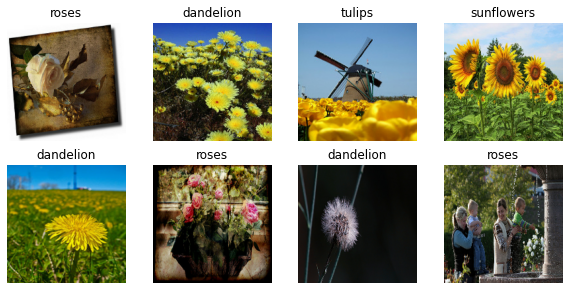

In [ ]:
#set up the canvas size to display images
classnames = train_dir.class_names

plt.figure(figsize=(10,10))
for images, labels in train_dir.take(1):
  for index in range(8):
    ax = plt.subplot(4,4,index+1)
    plt.imshow(images[index].numpy().astype('uint8'))
    plt.title(classnames[labels[index]])
    plt.axis('off')

<center><font size='4'><b>Use ResNet50 with keras</b></font>
<br>
We use all layers except the top layer that is done with include_top=False

In [ ]:
#Set up the model architecture
resNet50_model = Sequential()

#ResNet50 model that obtained from Keras Applications
# ResNet50 = tf.keras.applications.ResNet50
class_len = len(train_dir.class_names)

already_trained_model = tf.keras.applications.ResNet50(include_top=False,
                                 input_shape=(img_height,img_width,3),
                                 pooling='avg',
                                 classes=class_len,
                                 weights='imagenet')

for layer in already_trained_model.layers:
  layer.trainable = False
                               

<center><font size='4'><b>Add two more dense layers</b></font>
<br>
In the output layer, the softmax activation function is used and as a result, the values in the output layer are given in terms of probabilities. That is, all output neurons would have non-zero values, but the maximum value corresponds to the predicted class. If the sigmoid activation function were used, there would only be one neuron.

In [ ]:
#Add our own layers on top of alreay trained ResNet50 model
resNet50_model.add(already_trained_model)
resNet50_model.add(Flatten() )
resNet50_model.add(Dense(512,activation='relu') )
resNet50_model.add(Dense(5,activation='softmax') )

In [ ]:
resNet50_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
_________________________________________________________________


The above model summary highlights the importance of transfer learning. The summary shows that the ResNet50 model has more than 24 million trainable parameters and if we had to train the model from scratch it would have taken quite a lot of time and memory. This would definitely have increased the computational effort. However, when using an already trained model, only 1 million parameters need to be retrained again. This is because we have frozen most of the layers and as per our problem we added only two layers.

<center><font size='5'><b>Compile the model. </b></font>
<br>
Since we have five different labels, the categorical_cross entropy is used as the loss function. If there were two classes, the binary cross entropy would be used.

In [ ]:
#Compile and Train the model
resNet50_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

history = resNet50_model.fit(train_dir,validation_data=validation_dir,epochs=10)

Epoch 1/10
92/92 [==============================] - 420s 5s/step - loss: 0.7384 - accuracy: 0.7820 - val_loss: 0.4517 - val_accuracy: 0.8433
Epoch 2/10
92/92 [==============================] - 415s 5s/step - loss: 0.2975 - accuracy: 0.8900 - val_loss: 0.3710 - val_accuracy: 0.8638
Epoch 3/10
92/92 [==============================] - 406s 4s/step - loss: 0.1713 - accuracy: 0.9428 - val_loss: 0.3750 - val_accuracy: 0.8624
Epoch 4/10
92/92 [==============================] - 408s 4s/step - loss: 0.1025 - accuracy: 0.9717 - val_loss: 0.4781 - val_accuracy: 0.8365
Epoch 5/10
92/92 [==============================] - 406s 4s/step - loss: 0.0603 - accuracy: 0.9843 - val_loss: 0.3783 - val_accuracy: 0.8692
Epoch 6/10
92/92 [==============================] - 403s 4s/step - loss: 0.0331 - accuracy: 0.9952 - val_loss: 0.4038 - val_accuracy: 0.8747
Epoch 7/10
92/92 [==============================] - 404s 4s/step - loss: 0.0171 - accuracy: 0.9980 - val_loss: 0.4102 - val_accuracy: 0.8828
Epoch 8/10
92

In [ ]:
#Save the model
resNet50_model.save('ResNet50_With_2_Additonal_layers')

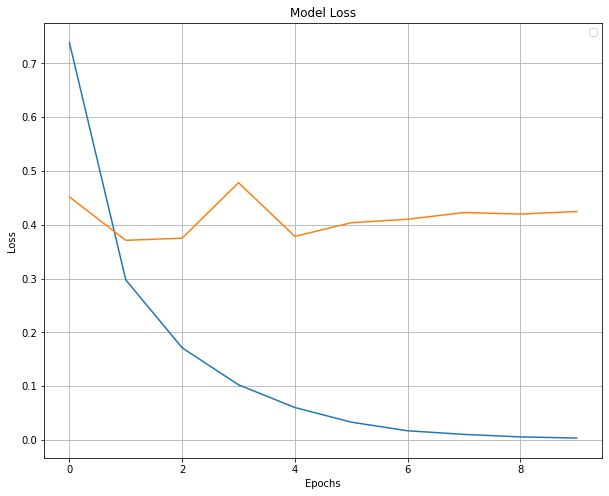

In [ ]:
#Visulaizing the performance of the model
plt.figure(figsize=(10,8))
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train','Validation'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.show()

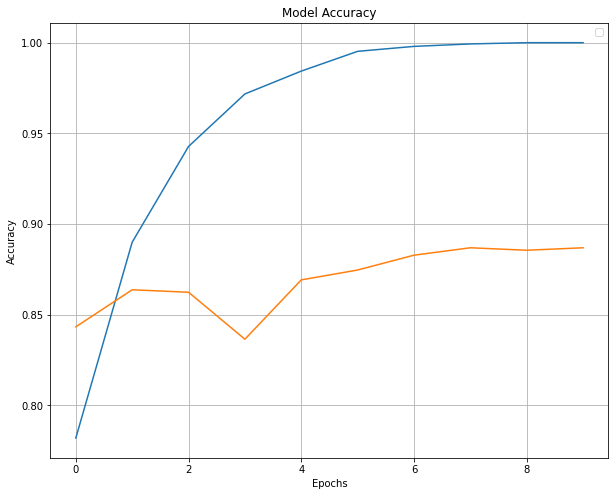

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train','Validation'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.show()

The chart shows that the model has 100% accuracy on the training data. However, the model could not reproduce the same accuracy on the validation dataset. This problem is often referred to as the overfitting problem. The reasons for this problem are manifold. We can investigate by changing the number of neurons in the dense layers, or dropping some neurons, etc.

The path to images
/root/.keras/datasets/flower_photos/daisy/14219214466_3ca6104eae_m.jpg


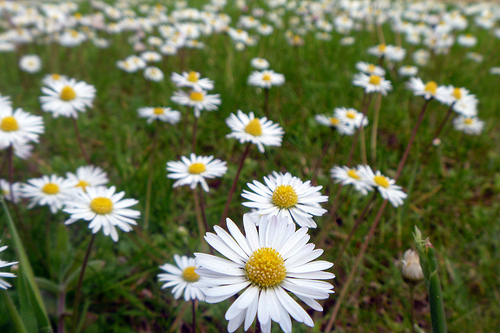

In [ ]:
# daisy = 'root/.keras/datasets/flower_photos/daisy/*'
daisy = list(dir_to_data.glob('daisy/*'))

print('The path to images')
print(daisy[50])

PIL.Image.open(str(daisy[1]))

In [ ]:
image        = cv2.imread(str(daisy[1]))
resize_image = cv2.resize(image,(img_height,img_width))
image        = np.expand_dims(resize_image,axis=0) 
prediction   = resNet50_model.predict(image)
output_class = classnames[np.argmax(prediction)]

print(f'The name given by the model prediction is {output_class}')

The name given by the model prediction is daisy


<center><font size='5'><b>Conclusion</b></font></center>

* I used the concept of transfer learning.

* Two additional layers are added and trained the model with slight modifications.

* The model shows 100% accuracy on the training data and ~89% accuracy on the validation data.

* Due to the distribution of the data in the five different classes, the softmax activation function is used on the outer layer

* With slight modifications, this model can be used to classify our own images or images of relatives. To do this, images must be stored in a different directory and the directory name must be considered as a label